# Can SLALOM model Transformer outputs better?

In this notebook, we train models on a linear dataset and compare the fit of different surrogate models (linear, GAM, SLALOM).
We compute quantiative and qualitative results to find out which model is more faithful in representing the output.

This notebook can be used to produce the results shown in Figure 4 of the paper.

## Part 1: Training models with the linear dataset.
First we study transformer models trained on a toy dataset where the tokens obey a linear relation.
If you have not already done so to use a previous notebook, first train the models using the script
```
./scripts/train_models_linear.sh 5
```
The second argument provides the number of runs, we use 5 runs in the paper.
Then update the following path to the one where the models where saved by the script.

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
os.chdir("..")

In [18]:
import torch
from experiment_utils.transformer_models import DistilBert, GPT2, Bert, Trainer

In [19]:
from transformers import AutoTokenizer

In [20]:
binomial = True
prefix = "models_lin_bin_rerun"
device = "cuda:0" ## Available device

First, we load all the trained models.

In [21]:
from experiment_utils.utils import compute_logits_for_single_token

In [23]:
## Load models
from collections import defaultdict
n_heads = 12

res_dict = defaultdict(lambda: defaultdict(list))
models_keys = []
model_list = []
for model in ["bert", "distilbert", "gpt2"]:
    #res_dict[model] = 
    for run in range(2):
        for n_layers in [1, 2, 4, 8, 12]:
            if "gpt2" in model:
                model_obj = GPT2(n_layer=n_layers, n_head=n_heads, pretrained=False)
                tokenizer = AutoTokenizer.from_pretrained('distilgpt2', use_fast=True)
            else:
                if model == "bert":
                    model_obj = Bert(n_layers=n_layers, n_heads=n_heads, pretrained=False)
                else:
                    model_obj = DistilBert(n_layers=n_layers, n_heads=n_heads, pretrained=False)
            
                tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
            model_str = f"{prefix}/sparsebow_{model}_{n_layers}_r{run}.pt"
            model_obj.model.load_state_dict(torch.load(model_str))
            model_obj.model.eval()
            model_obj.model = model_obj.model.to(device)
            
            ## Now run forward passes
            res = compute_logits_for_single_token(tokenizer, model_obj.model, n_max=30, use_cls="bert" in model, use_device=device)
            res = res[:,:,1]-res[:,:,0]
            res_dict[model][n_layers].append(res) 
            model_list.append(model_obj.model.to("cpu"))
            models_keys.append((model, n_layers, run))
            print(model, n_layers, run)  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_454263/2222403874.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We

bert 1 0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert 2 0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert 4 0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert 8 0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert 12 0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert 1 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert 2 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert 4 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert 8 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert 12 1
distilbert 1 0
distilbert 2 0
distilbert 4 0
distilbert 8 0
distilbert 12 0
distilbert 1 1
distilbert 2 1
distilbert 4 1
distilbert 8 1
distilbert 12 1
gpt2 1 0
gpt2 2 0
gpt2 4 0
gpt2 8 0
gpt2 12 0
gpt2 1 1
gpt2 2 1
gpt2 4 1
gpt2 8 1
gpt2 12 1


In [24]:
len(models_keys)

30

In [25]:
len(model_list)

30

## Explain the models with SLALOM vs Linear vs. GAM

In [36]:
# This function performs model forward passes on different inputs, which will be used to fit the surrogate models.
n_samples_offline = 100
from tqdm import tqdm
def sample_offline_dataset(n_samples_offline, dataset_bert, dataset_gpt, models, model_keys):
    """ 
        Sample a dataset of n_samples_offline synthetic samples from the dataset. These will be used to 
        Evaluate the fit of the model.
        We need two versions of the dataset, due to the different tokenizers of bert and gpt-style models.
        Run all models in the list models and compute the outputs.
    """
    model_scores, true_scores, true_scores_gpt, feature_vects, feature_vects_gpt, labels, labels_gpt = [], [], [], [], [], [], []
    batch_size = 64
    mydl_bert, mydl_gpt = DataLoader(dataset_bert, batch_size=batch_size), DataLoader(dataset_gpt, batch_size=batch_size)
    samples_done = 0
    iterator_bert = iter(mydl_bert)
    iterator_gpt = iter(mydl_gpt)
    with tqdm(total=n_samples_offline) as pbar:
        while samples_done < n_samples_offline: 
            #print(samples_done)
            sample_bert, sample_gpt = next(iterator_bert), next(iterator_gpt)
            with torch.no_grad():
                out_list = []
                for m, mkey in zip(models, model_keys):
                    m.to(device)
                    if "bert" in mkey[0]: 
                        logs = m(sample_bert["input_ids"].to(device), attention_mask = sample_bert["attention_mask"].to(device))["logits"]
                    else:
                        logs = m(sample_gpt["input_ids"].to(device), attention_mask = sample_gpt["attention_mask"].to(device))["logits"]
                    out_list.append(logs)
                    m.to("cpu")
            logs = torch.stack(out_list)
            #print(logs.shape)
            logs = logs[:,:,1]-logs[:,:,0]
            feature_vect_bert = (dataset_bert.word_toks.reshape(1,-1,1) == sample_bert["input_ids"].unsqueeze(1)) # samples 1.
            feature_vect_gpt = (dataset_gpt.word_toks.reshape(1,-1,1) == sample_gpt["input_ids"].unsqueeze(1)) # samples 1.
            feature_vects.append(feature_vect_bert)
            feature_vects_gpt.append(feature_vect_gpt)
            labels.append(sample_bert["label"])
            labels_gpt.append(sample_gpt["label"])
            model_scores.append(logs)
            true_scores.append(sample_bert["gt_score"])
            true_scores_gpt.append(sample_gpt["gt_score"])
            samples_done += batch_size
            pbar.update(batch_size)
    labels = torch.cat(labels, dim=0)
    labels_gpt = torch.cat(labels_gpt, dim=0)
    features = torch.cat(feature_vects, dim=0)
    features_gpt = torch.cat(feature_vects_gpt, dim=0)
    true_scores = torch.cat(true_scores, dim=0)
    true_scores_gpt = torch.cat(true_scores_gpt, dim=0)
    model_scores = torch.cat(model_scores, dim=1).t()
    return labels, labels_gpt, features, features_gpt, true_scores, true_scores_gpt, model_scores

In [37]:
from experiment_utils.bow_dataset import SparseBoWDataset

words_dict = {"the": (0.2, 0.0), "we": (0.2, 0.0), "movie": (0.2, 0.0), "watch": (0.2, 0.0),
      "best": (0.06, 1.0), "perfect": (0.06, 1.5), "good": (0.08, 0.7),
      "worst": (0.06, -1.5), "poor": (0.06, -1.0),"ok": (0.08, -0.7)}

tokenizer1 = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
myds1 = SparseBoWDataset(tokenizer1, all_words_dict = words_dict, fixed_len=False, binomial_sampling=binomial, ds_length=12000)

tokenizer2 = AutoTokenizer.from_pretrained('distilgpt2', use_fast=True)
myds2 = SparseBoWDataset(tokenizer2, all_words_dict =  words_dict, start_tok=None, end_tok=None, fixed_len=False, binomial_sampling=binomial, ds_length=12000)
    
from torch.utils.data import DataLoader

In [38]:
myds2.cats.probs

tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.0500, 0.0500, 0.0667, 0.0500, 0.0500,
        0.0667])

In [39]:
# We are now performing 10000 forward passes with all of the models.
_, _, features, features_gpt, _, _, model_scores =  sample_offline_dataset(10000, myds1, myds2, model_list, models_keys)


10048it [09:13, 18.15it/s]                                                                                                                                                                                     


In [84]:
model_scores.shape

torch.Size([10048, 30])

In [40]:
model_scores.shape

torch.Size([10048, 30])

In [41]:
model_scores.shape

torch.Size([10048, 30])

In [42]:
torch.save((features, features_gpt, model_scores), "datasets/c_feature_scores.pt")

## Fit models: GAM, Linear Model etc.

We now fit the Linear and the GAM model to the computed outputs.

In [45]:
## Num models to fit.
from sklearn.linear_model import LinearRegression, Lasso
features = features.cpu()
model_scores = model_scores.cpu()
myLRs = []
myGAMs = []
for m, mkey in zip(range(model_scores.shape[1]), models_keys):
    if "bert" in mkey[0]: 
        features_use = features
    else:
        features_use = features_gpt
    myLR = LinearRegression()
    myLR.fit(torch.sum(features_use, dim=-1), model_scores[:, m])
    myLRs.append(myLR)
    myGAM = Lasso(alpha=0.01)
    myGAM.fit(features_use.reshape(len(features_use), -1), model_scores[:,m])
    myGAMs.append(myGAM)

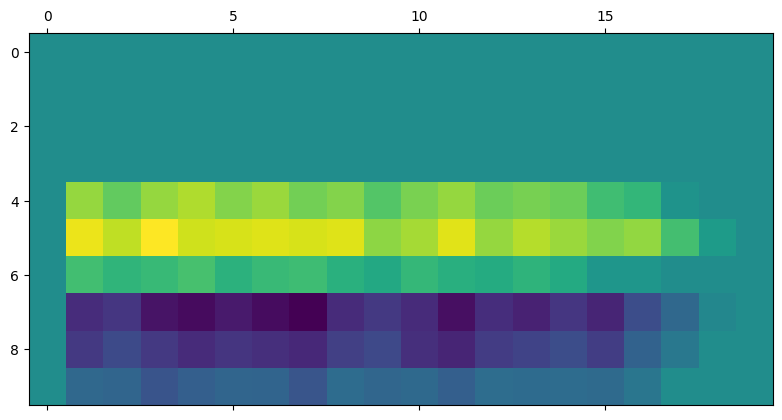

In [49]:
import matplotlib.pyplot as plt
plt.matshow(myGAMs[12].coef_.reshape(10,-1)[:,:20])

## Fit models: SLALOM

In [52]:
from slalom_explanations.slalom_helpers import MyLittleSLALOM
from slalom_explanations.slalom_helpers import fit_slalom_sgd

from torch.utils.data import TensorDataset
from torch.optim import Adam
import math

In [53]:
torch.sum(features, dim=-1).shape

torch.Size([10048, 10])

In [54]:
mySlaloms = []
perform_epochs = 100
for m in range(model_scores.shape[1]):
    print("Fitting model", m)
    if "bert" in models_keys[m][0]:
        _, _, slalom = fit_slalom_sgd(myds1, torch.sum(features, dim=-1), model_scores[:,m].cpu(), num_eps=perform_epochs, use_cls=False)
    else:
        _, _, slalom = fit_slalom_sgd(myds2, torch.sum(features_gpt, dim=-1), model_scores[:,m].cpu(), num_eps=perform_epochs, use_cls=False)
    mySlaloms.append(slalom)

Fitting model 0
10
1.8405538108024972
0.5552055464979396
0.3168972820521137
0.29630744791541674
0.31229355668778386
0.32383009584423045
0.33031152903721783
0.3338461137991619
0.3357614233199735
0.33679474639042944
Fitting model 1
10
1.535180322201136
0.41570067684755335
0.2761991549430615
0.2936340534386466
0.33441391032201767
0.3631872650313778
0.3820771141059153
0.39476829432784044
0.4035331404689032
0.409722634852286
Fitting model 2
10
1.4808310515830359
0.4619735131102371
0.46056696983028883
0.45988381097559305
0.4591394203148162
0.45860209676759817
0.45829877578618455
0.4581391689092264
0.45805744154400285
0.45801641785563396
Fitting model 3
10
0.7028502457296367
0.037566875267809746
0.013527398442409239
0.005805589510597005
0.002624585703705203
0.001208123661612122
0.0006418637752216251
0.00044149279079249375
0.00018355505604818835
7.331283171926462e-05
Fitting model 4
10
0.0007507372889661414
6.683496802303626e-08
7.224806529737812e-08
1.072679859797608e-07
0.0001391363097653198

## Forward random samples and compute errors.

In [55]:
n_samples_test = 500
with torch.no_grad():
    _, _, features_test, features_test_gpt, _, _, model_scores_test =  sample_offline_dataset(n_samples_test, myds1, myds2, model_list, models_keys)

512it [00:26, 19.58it/s]                                                                                                                                                                                       


In [56]:
model_scores_test.shape

torch.Size([512, 30])

In [57]:
def forward_samples(features, model_lr, model_gam, model_slalom, use_cls=True):
    score_lin = model_lr.predict(torch.sum(features, dim=-1))
    score_gam = model_gam.predict(features.reshape(len(features),-1))
    if use_cls:
        ext_feat = torch.cat((torch.sum(features, dim=-1), torch.ones(len(features), 2)), dim=1)
    else:
        ext_feat = torch.sum(features, dim=-1)
    score_slalom = model_slalom.forward_feature_vects(ext_feat)[:,1].detach().cpu()
    return score_lin, score_gam, score_slalom

In [58]:
lin_all_rnd = {}
gam_all_rnd = {}
slalom_all_rnd = {}
true_all_rnd = {}
for m in range(len(models_keys)):
    use_cls=False
    if "bert" in models_keys[m][0]:
        score_lin, score_gam, score_slalom = forward_samples(features_test, myLRs[m], myGAMs[m], mySlaloms[m], use_cls=use_cls)
    else:
        score_lin, score_gam, score_slalom = forward_samples(features_test_gpt, myLRs[m], myGAMs[m], mySlaloms[m], use_cls=use_cls)
    lin_all_rnd[models_keys[m]] = torch.tensor(score_lin) # Pred of linear model
    gam_all_rnd[models_keys[m]] = torch.tensor(score_gam) # Pred of GAM
    slalom_all_rnd[models_keys[m]] = score_slalom # Pred of SLALOM
    true_all_rnd[models_keys[m]] = model_scores_test[:,m].flatten().cpu() # Pred of transformer model.

In [59]:
true_all_rnd.keys()

dict_keys([('bert', 1, 0), ('bert', 2, 0), ('bert', 4, 0), ('bert', 8, 0), ('bert', 12, 0), ('bert', 1, 1), ('bert', 2, 1), ('bert', 4, 1), ('bert', 8, 1), ('bert', 12, 1), ('distilbert', 1, 0), ('distilbert', 2, 0), ('distilbert', 4, 0), ('distilbert', 8, 0), ('distilbert', 12, 0), ('distilbert', 1, 1), ('distilbert', 2, 1), ('distilbert', 4, 1), ('distilbert', 8, 1), ('distilbert', 12, 1), ('gpt2', 1, 0), ('gpt2', 2, 0), ('gpt2', 4, 0), ('gpt2', 8, 0), ('gpt2', 12, 0), ('gpt2', 1, 1), ('gpt2', 2, 1), ('gpt2', 4, 1), ('gpt2', 8, 1), ('gpt2', 12, 1)])

Print the results as a nice table (appendix)

In [86]:
import numpy as np
n_runs = 2
#lin_all, gam_all, slalom_all, true_all = lin_all_rnd, gam_all_rnd, slalom_all_rnd, true_all_rnd
for i, (model_arch, model_arch_str) in enumerate(zip(["gpt2", "distilbert", "bert"], ["GPT-2", "DistilBERT", "BERT"])):
    for layers in [1, 2, 4, 8, 12]:
        res_str = f"{model_arch_str} & {layers} & "
        for model, scores_use in zip(["linear", "GAM", "SLALOM"], [lin_all_rnd, gam_all_rnd, slalom_all_rnd]):
            res_list = []
            for r in range(n_runs): 
                key = (model_arch, layers, r)
                res_list.append(torch.mean((scores_use[key]-true_all_rnd[key]).pow(2)).item()*100)
            narr = np.array(res_list)
            if model != "SLALOM":
                res_str += r"\wstd{"+ f"{narr.mean():.2f}"+  r"}{" + f"{narr.std()/math.sqrt(n_runs):.2f}" +r"} & "
            else:
                res_str += r"\bwstd{"+ f"{narr.mean():.2f}"+  r"}{" + f"{narr.std()/math.sqrt(n_runs):.2f}" +r"} \\"
        print(res_str)
    print(r"\midrule")

GPT-2 & 1 & \wstd{55.30}{13.64} & \wstd{70.08}{11.22} & \bwstd{27.60}{10.73} \\
GPT-2 & 2 & \wstd{41.32}{0.70} & \wstd{63.69}{2.18} & \bwstd{17.95}{3.24} \\
GPT-2 & 4 & \wstd{54.49}{15.11} & \wstd{68.90}{11.89} & \bwstd{30.19}{4.45} \\
GPT-2 & 8 & \wstd{61.10}{0.81} & \wstd{69.44}{4.39} & \bwstd{40.32}{2.78} \\
GPT-2 & 12 & \wstd{53.73}{12.17} & \wstd{68.84}{10.70} & \bwstd{34.24}{9.21} \\
\midrule
DistilBERT & 1 & \wstd{24.30}{5.09} & \wstd{50.93}{3.65} & \bwstd{12.31}{4.40} \\
DistilBERT & 2 & \wstd{25.92}{5.47} & \wstd{58.44}{8.65} & \bwstd{13.40}{3.59} \\
DistilBERT & 4 & \wstd{54.44}{9.12} & \wstd{85.41}{8.08} & \bwstd{37.79}{6.31} \\
DistilBERT & 8 & \wstd{16.30}{10.80} & \wstd{19.27}{12.90} & \bwstd{7.29}{4.43} \\
DistilBERT & 12 & \wstd{0.00}{0.00} & \wstd{0.00}{0.00} & \bwstd{0.00}{0.00} \\
\midrule
BERT & 1 & \wstd{24.51}{1.52} & \wstd{57.44}{1.27} & \bwstd{7.92}{0.73} \\
BERT & 2 & \wstd{29.59}{9.96} & \wstd{62.23}{12.75} & \bwstd{15.66}{6.41} \\
BERT & 4 & \wstd{64.10}{5.16

## Compute the qualitative results.

In [68]:
def forward_other_models_for_single_token(tokenizer, model_lr, model_gam, model_slalom, token_list, n_max=10, input_str="perfect", neutral_input="the", sample_len=30, offset=0):
    logit_results = []
    input_tok = torch.tensor(tokenizer.convert_tokens_to_ids(input_str)).reshape(1)
    neutal_tok = torch.tensor(tokenizer.convert_tokens_to_ids(neutral_input)).reshape(1)
    score_lin, score_gam, score_slalom = [], [], []
    
    ## Evaluate neutral input
    
    input_pad = torch.zeros(sample_len)
    input_pad[offset] = neutal_tok
    input_to_features =  (token_list.reshape(-1,1) == input_pad.unsqueeze(0))
    #print(input_to_features.shape)
    
    score_lin.append(model_lr.predict(torch.sum(input_to_features, dim=-1).reshape(1,-1))[0])
    score_gam.append(model_gam.predict(input_to_features.reshape(1,-1))[0])
    
    ext_feat = torch.sum(input_to_features, dim=-1).reshape(1,-1)
    score_slalom.append(model_slalom.forward_feature_vects(ext_feat)[0,1].item())

    with torch.no_grad():
        input = input_tok
        for i in range(n_max):
            input_pad = torch.zeros(sample_len)
            input_pad[offset:len(input)+offset] = input
            input_to_features =  (token_list.reshape(-1,1) == input_pad.unsqueeze(0))
            #print(input_to_features.shape)
            
            score_lin.append(model_lr.predict(torch.sum(input_to_features, dim=-1).reshape(1,-1))[0])
            score_gam.append(model_gam.predict(input_to_features.reshape(1,-1))[0])
            ext_feat = torch.sum(input_to_features, dim=-1).reshape(1,-1)
            score_slalom.append(model_slalom.forward_feature_vects(ext_feat)[0,1].item())
            
            input = torch.cat((input, input_tok), dim=0)  
    return score_lin, score_gam, score_slalom

In [69]:
lin_all = {}
gam_all = {}
slalom_all = {}
true_all = {}
for m in range(len(models_keys)):
    if "bert" in models_keys[m][0]:
        score_lin, score_gam, score_slalom = forward_other_models_for_single_token(tokenizer1, myLRs[m], myGAMs[m], mySlaloms[m], myds1.word_toks, n_max=30, sample_len = 32, offset=1)
    else:
        score_lin, score_gam, score_slalom = forward_other_models_for_single_token(tokenizer2, myLRs[m], myGAMs[m], mySlaloms[m], myds2.word_toks, n_max=30, sample_len = 30)
    lin_all[models_keys[m]] = torch.tensor(score_lin)
    gam_all[models_keys[m]] = torch.tensor(score_gam)
    slalom_all[models_keys[m]] = torch.tensor(score_slalom)
    true_all[models_keys[m]] = res_dict[models_keys[m][0]][models_keys[m][1]][models_keys[m][2]].flatten()

In [70]:
models_keys[1]

('bert', 2, 0)

In [71]:
gam_all.keys()

dict_keys([('bert', 1, 0), ('bert', 2, 0), ('bert', 4, 0), ('bert', 8, 0), ('bert', 12, 0), ('bert', 1, 1), ('bert', 2, 1), ('bert', 4, 1), ('bert', 8, 1), ('bert', 12, 1), ('distilbert', 1, 0), ('distilbert', 2, 0), ('distilbert', 4, 0), ('distilbert', 8, 0), ('distilbert', 12, 0), ('distilbert', 1, 1), ('distilbert', 2, 1), ('distilbert', 4, 1), ('distilbert', 8, 1), ('distilbert', 12, 1), ('gpt2', 1, 0), ('gpt2', 2, 0), ('gpt2', 4, 0), ('gpt2', 8, 0), ('gpt2', 12, 0), ('gpt2', 1, 1), ('gpt2', 2, 1), ('gpt2', 4, 1), ('gpt2', 8, 1), ('gpt2', 12, 1)])

In [85]:
true_all[('gpt2', 2, 0)]

tensor([0.8642, 6.4735, 6.3995, 6.4757, 6.5338, 6.4811, 6.4895, 6.5053, 6.4987,
        6.5342, 6.5772, 6.6304, 6.6564, 6.6673, 6.7206, 6.7506, 6.7892, 6.8271,
        6.8569, 6.8807, 6.9003, 6.9157, 6.9194, 6.9291, 6.9432, 6.9421, 6.9595,
        6.9581, 6.9691, 6.9718, 6.9582])

In [73]:
#torch.save((lin_all, gam_all, slalom_all, true_all), f"data/exp_c_final.pt")

In [74]:
import matplotlib.pyplot as plt

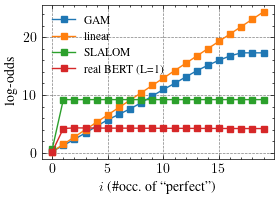

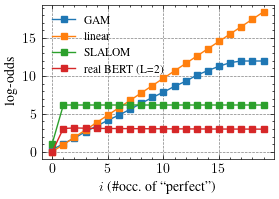

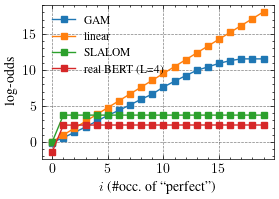

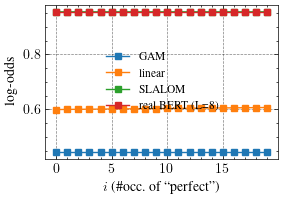

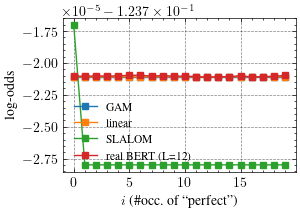

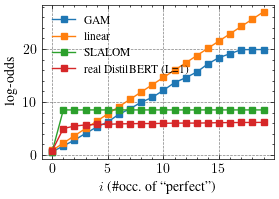

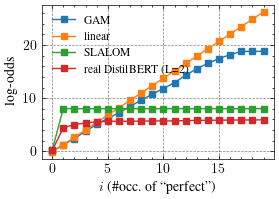

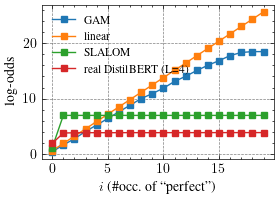

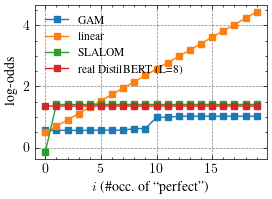

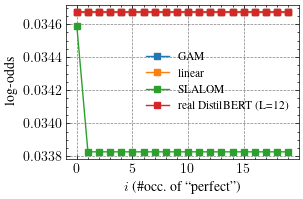

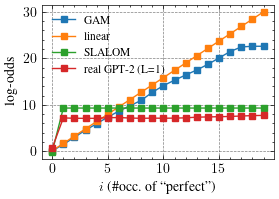

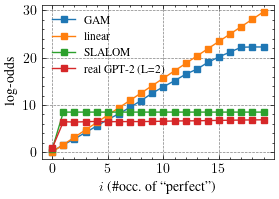

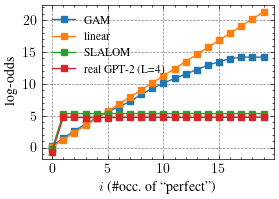

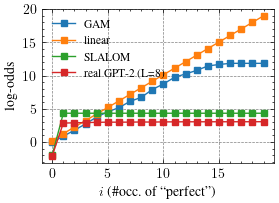

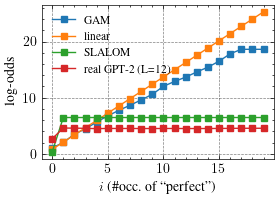

In [77]:
## Create the figures nicely.
plt.style.use('./figures/matplot.mplstyle')
transformer_plot_keys = {"bert": "BERT", "distilbert": "DistilBERT", "gpt2": "GPT-2"}
pts_lim = 20
marker_sz = 4
run = 0
for i, model_arch in enumerate(["bert", "distilbert", "gpt2"]):
    #lin_all, gam_all, slalom_all, true_all = torch.load(f"data/exp_b_{model_arch}.pt")
    for layers in [1, 2, 4, 8, 12]:
        f, ax = plt.subplots()
        key = (model_arch, layers, run)
        plt.plot(gam_all[key][:pts_lim], "-s", label="GAM", markersize=marker_sz)
        ax.plot(lin_all[key][:pts_lim], "-s", label="linear", markersize=marker_sz)
        ax.plot(slalom_all[key][:pts_lim], "-s", label="SLALOM", markersize=marker_sz)
        ax.plot(true_all[key][:pts_lim], "-s", label = f"real {transformer_plot_keys[model_arch]} (L={layers})", markersize=marker_sz)
        ax.legend(fontsize="small")
        ax.set_ylabel("log-odds")
        ax.set_xlabel(r"$i$ (\#occ. of ``perfect'')")
        f.set_size_inches(3, 2)
        #f.savefig(f"figures/C_lines_{model_arch}_{layers}.pdf")

## Now forward Random Features and plot predicted vs true log-odds

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


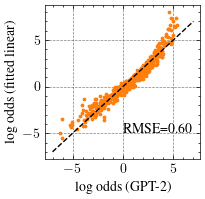

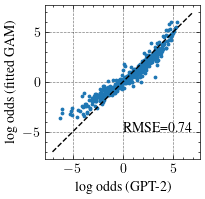

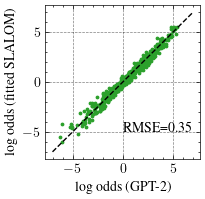

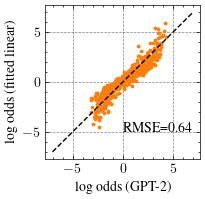

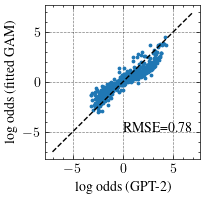

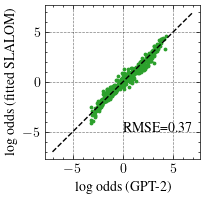

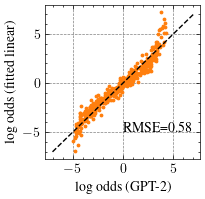

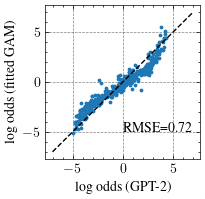

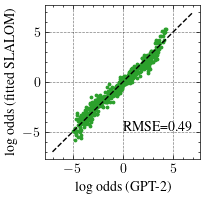

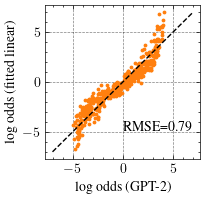

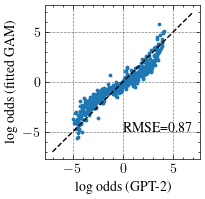

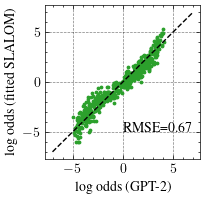

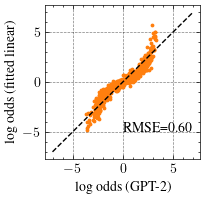

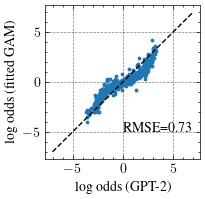

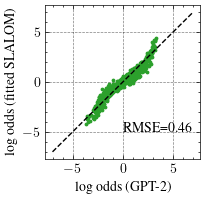

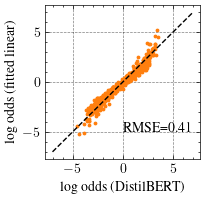

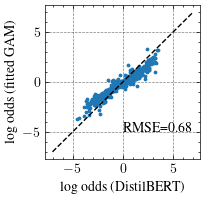

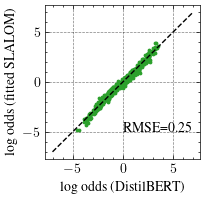

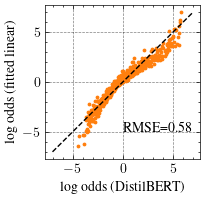

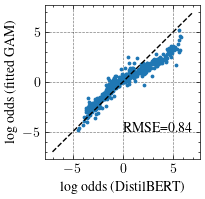

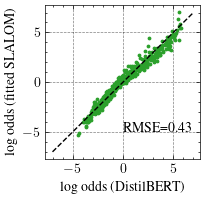

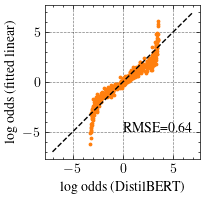

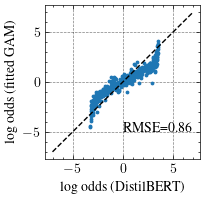

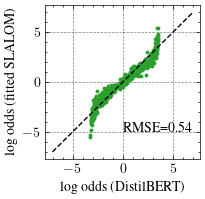

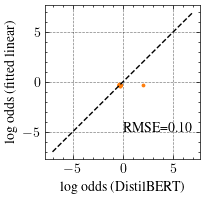

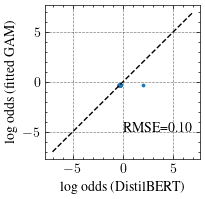

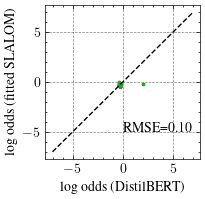

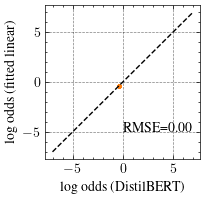

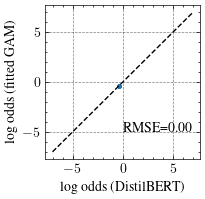

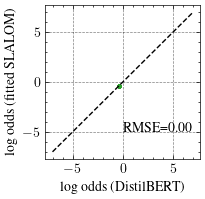

In [88]:
plt.style.use('./figures/matplot.mplstyle')
transformer_plot_keys = {"bert": "BERT", "distilbert": "DistilBERT", "gpt2": "GPT-2"}
colors_models = {"linear": "tab:orange", "GAM": "tab:blue", "SLALOM": "tab:green"}
pts_lim = 20
sz = 3
lim = 7.0
run = 1
for i, model_arch in enumerate(["gpt2", "distilbert"]):
    #lin_all, gam_all, slalom_all, true_all = torch.load(f"data/exp_c.pt")
    for layers in [1, 2, 4, 8, 12]:
        for model, scores_use in zip(["linear", "GAM", "SLALOM"], [lin_all_rnd, gam_all_rnd, slalom_all_rnd]):
            f, ax = plt.subplots()
            # Calculate and print rmse
            key = (model_arch, layers, run)
            ax.plot([-lim, lim], [-lim, lim], "--k")
            ax.scatter(true_all_rnd[key], scores_use[key], sz, c=colors_models[model])
            ax.set_xlabel(f"log odds ({transformer_plot_keys[model_arch]})")
            ax.set_ylabel(f"log odds (fitted {model})")
            #ax.set_xlim([-lim, lim])
            #ax.set_ylim([-lim, lim])
            mse = torch.sqrt(torch.mean((scores_use[key]-true_all_rnd[key]).pow(2)))
            ax.text(0,-lim+2, s=f"RMSE={mse.item():.2f}")
            f.set_size_inches(2, 2)
            #f.savefig(f"figures/C_scatter_{model_arch}_{layers}_{model}.pdf")

## Part 2: Train models on a SLALOM ground truth to verify the recovery properties

**Training models with the SLALOM dataset**

In the second part of this notebook, we are considering a dataset where the ground truth realation has the form of SLALOM.
If you have not already done so to use a previous notebook, first train the models using the script
```
./scripts/train_models_slalom.sh 
```
Then update the following path to the one where the models where saved by the script.

In [90]:
words_dict = torch.load("datasets/slalom_200words.pt")

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [93]:
from experiment_utils.bow_dataset import SLALOMDataset
from torch.utils.data import DataLoader
def sample_features_slalom(n_samples, vocab_size, sample_max_len=8):
    words_dict_use = {k: words_dict[k] for k in list(words_dict.keys())[:vocab_size]}
    myds = SLALOMDataset(tokenizer, all_words_dict = words_dict_use, ds_length=20000, start_tok="[CLS]", sample_max_length=sample_max_len)
    mydl = DataLoader(myds, batch_size=n_samples)
    batch = next(iter(mydl))
    features = (myds.word_toks.reshape(-1,1,1) == batch["input_ids"].unsqueeze(0)).sum(dim=-1).t()
    return batch, features, batch["score"], myds

In [105]:
## Load models
import os
n_heads = 12
device = "cpu"
prefix="models_slalom"
model_list = []
models_keys = []
model = "distilbert"
sentence_len = 8
n_layers = 2
vocab_size_list = [16, 32, 64, 128, 200]
for vocab_size in vocab_size_list:
    for run in range(1):
        model_str = f"{prefix}/v{vocab_size}/slalom200_{model}_{n_layers}_r{run}.pt"
        if not os.path.isfile(model_str):
            continue
        if "distilgpt2" in model:
            model_obj = DistilGPT2(n_layer=n_layers, n_head=n_heads)
            tokenizer = AutoTokenizer.from_pretrained('distilgpt2', use_fast=True, pretrained=False)
        else:
            if model == "bert":
                model_obj = Bert(n_layers=n_layers, n_heads=n_heads)
            else:
                model_obj = DistilBert(n_layers=n_layers, n_heads=n_heads, pretrained=False)
            tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
        model_obj.model.load_state_dict(torch.load(model_str))
        model_obj.model.eval()
        model_obj.model = model_obj.model.to(device)
        model_list.append(model_obj.model)
        ## Now run forward passe
        models_keys.append((model, vocab_size, n_layers, run, sentence_len))
        print(model, vocab_size, n_layers)  

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


distilbert 16 2
distilbert 32 2
distilbert 64 2
distilbert 200 2


In [106]:
mySlaloms = []
n_samples = 10000
for m in range(len(models_keys)):
    use_cls = False
    with torch.no_grad():
        if len(models_keys[m]) > 4:
            print(models_keys[m][4])
            batch, feat, gt_scores, myds = sample_features_slalom(n_samples, models_keys[m][1], sample_max_len=models_keys[m][4])
        else:
            batch, feat, gt_scores, myds = sample_features_slalom(n_samples, models_keys[m][1], sample_max_len=8)
        result = model_list[m](batch["input_ids"].to(device), attention_mask = batch["attention_mask"].to(device))["logits"]
        result = result[:,1]-result[:,0]
    _, _, slalom = fit_slalom_sgd(myds, feat, result.detach().cpu(), num_eps=100, use_cls=use_cls)
    mySlaloms.append(slalom)

8
16
0.9184783819496383
0.08596463479457679
0.05572601058563116
0.048851910996486586
0.04801494576432727
0.04809256606351921
0.04819031670037436
0.048237120694325925
0.04825646984405746
0.04826402980530778
8
32
0.6487983940243982
0.07262880014438375
0.0691810846483824
0.06968008183118485
0.0702502054189414
0.07052970160760923
0.07064139743358146
0.0706850553046826
0.07070255371516296
0.07070983109363543
8
64
0.4920589188239866
0.08087587165252247
0.07792055977640198
0.07821758268097188
0.07843899807126334
0.07850162205683121
0.07851882555592157
0.07852235416499646
0.07852193607758043
0.07852082116692106
8
200
0.6091316421901283
0.1720831921419468
0.16834717637762492
0.17004617441746883
0.16610710764989822
0.1599478412339399
0.15434729078394055
0.14993741125419824
0.14666793766021907
0.14432859389189817


## Run scatter plots

In [107]:
from torch.utils.data import DataLoader

n_samples_test = 200
res_dict ={}
for m in range(len(models_keys)):
    use_cls = False
    batch, feat, model_scores, myds = sample_features_slalom(n_samples_test, models_keys[m][1], sample_max_len=8 if len(models_keys[m]) < 4 else models_keys[m][4])
    slalomscores = mySlaloms[m].forward_feature_vects(feat)[:,1].detach().cpu()
    gt_scores = model_list[m](batch["input_ids"].to(device), attention_mask= batch["attention_mask"])["logits"].detach().cpu()
    result = gt_scores[:,1]-gt_scores[:,0]
    res_dict[tuple(models_keys[m])] = (result, slalomscores)

In [108]:
res_dict.keys()

dict_keys([('distilbert', 16, 2, 0, 8), ('distilbert', 32, 2, 0, 8), ('distilbert', 64, 2, 0, 8), ('distilbert', 200, 2, 0, 8)])

('distilbert', 16, 2, 0, 8)
('distilbert', 32, 2, 0, 8)
('distilbert', 64, 2, 0, 8)
('distilbert', 200, 2, 0, 8)


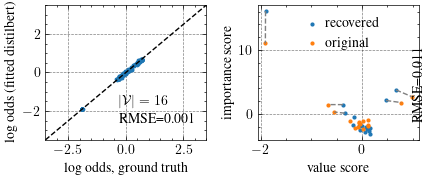

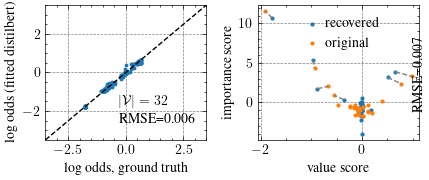

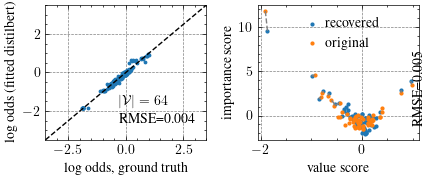

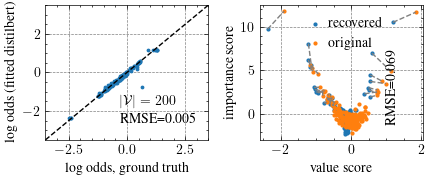

In [110]:
import matplotlib.pyplot as plt
plt.style.use('./figures/matplot.mplstyle')
transformer_plot_keys = {"bert": "BERT", "distilbert": "DistilBERT", "distilgpt2": "GPT-2"}
colors_models = {"linear": "tab:orange", "GAM": "tab:blue", "SLALOM": "tab:green"}
pts_lim = 20
sz = 3
lim = 3.5
sgd_rmse_logit_list = []
sgd_rmse_param_list =  []
for m, mykey in enumerate(res_dict.keys()):
    print(mykey)
    model_arch, vocab_size, n_layers, _, _ = mykey
    if n_layers != 2:
        continue
    #print(vocab_size, n_layers) 
    f, ax = plt.subplots(1, 2)
    # Calculate and print rmse
    ax[0].plot([-lim, lim], [-lim, lim], "--k")
    ax[0].scatter(res_dict[mykey][0], res_dict[mykey][1], sz, c="tab:blue")
    ax[0].set_xlabel(f"log odds, ground truth")
    ax[0].set_ylabel(f"log odds (fitted {model})")
    ax[0].set_xlim([-lim, lim])
    ax[0].set_ylim([-lim, lim])
    mse = torch.sqrt(torch.mean(res_dict[mykey][0]-res_dict[mykey][1]).pow(2))
    sgd_rmse_logit_list.append(mse.item())
    ax[0].text(-0.3,-lim+1.8, s=r"$\lvert\mathcal{V}\rvert="+str(vocab_size)+"$")
    ax[0].text(-0.3,-lim+0.9, s=f"RMSE={mse.item():.3f}")
    ri1 = mySlaloms[m].my_importance[1:].detach()
    ri1 = ri1-ri1.mean()
     
    ax[1].scatter(mySlaloms[m].my_values[1:].detach(), ri1, 4, label="recovered")
    slalom_model_scores = torch.stack((mySlaloms[m].my_values[1:].detach(), ri1), dim=1)
    words_dict_use = torch.tensor([[words_dict[k][2], words_dict[k][1]] for k in list(words_dict.keys())[:vocab_size]])
    words_dict_use[:,1] = words_dict_use[:,1]-words_dict_use[:,1].mean()
    ax[1].scatter(words_dict_use[:,0],  words_dict_use[:,1] , 4, label="original")
    #ax[1].set_title(f"{vocab_size}, {n_layers}")
    for i in range(len(words_dict_use[:,1])):
        if torch.abs(words_dict_use[i,0]) > 0.5:
            plt.plot([mySlaloms[m].my_values[i+1].detach(), words_dict_use[i,0]],[ri1[i], words_dict_use[i,1]], "--", c="0.5")
    f.set_size_inches(4.5, 2)
    mse = torch.sqrt(torch.mean(slalom_model_scores-words_dict_use).pow(2))
    sgd_rmse_param_list.append(mse.item())
    ax[1].text(1,-1, s=f"RMSE={mse.item():.3f}", rotation="vertical")
    ax[1].set_xlabel("value score")
    ax[1].set_ylabel("importance score")
    ax[1].legend(handletextpad=-0.1, loc = "upper center")
    plt.tight_layout()
    #f.savefig(f"figures/D_scatter_{model_arch}_{n_layers}_{vocab_size}.pdf")